# 3-я лабораторная по математической статистике (Саськов Л. К.)

## Задание 1: Построить ассимптотические доверительные интервалы для параметров Пуассона, Бернулли и экспоненциального
___

### 1) Генерируем выборку

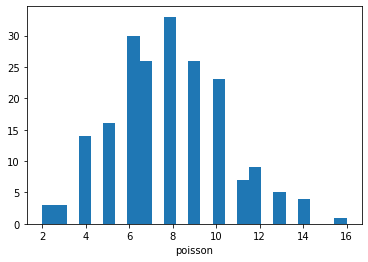

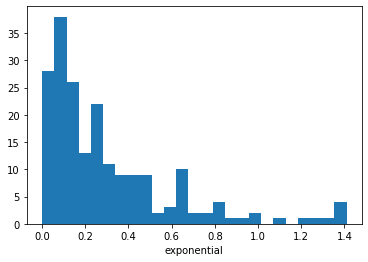

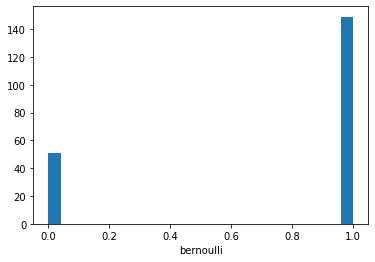

In [34]:
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt

distr_size = 200
distributions = {
    "poisson": np.random.poisson(lam=8, size=distr_size),
    # В numpy f = 1/scale * exp(-x/scale), то есть в стандартных обозначениях lambda = 3
    "exponential": np.random.exponential(scale=1/3, size=distr_size), 
    "bernoulli": st.bernoulli.rvs(size = distr_size , p = 0.8)
}

for distr_key in distributions:
  plt.hist(distributions[distr_key], bins=25)
  plt.xlabel(distr_key)
  plt.show()

### 2) Посчитаем ассимптотические доверительные интервалы

Формула для доверительного интервала параметра Бернулли: $\left( H-{{u}_{1-\alpha /2}}\sqrt{\frac{H(1-H)}{n}};H+{{u}_{1-\alpha /2}}\sqrt{\frac{H(1-H)}{n}} \right)$

In [3]:
def get_gauss_quantile(q):
    return st.norm.ppf(q)

error = 0.05

In [4]:
# Бернулли
# Посчитаем эффективную оценку p:
h = sum(distributions["bernoulli"]) / distr_size
deviation = get_gauss_quantile(1 - error/2) * (h * (1 - h) / distr_size) ** 0.5
a_p = h - deviation
b_p = h + deviation
print(f"Interval for p in Bernoulli: [{a_p}; {b_p}]" )

Interval for p in Bernoulli: [0.75009039253562; 0.85990960746438]


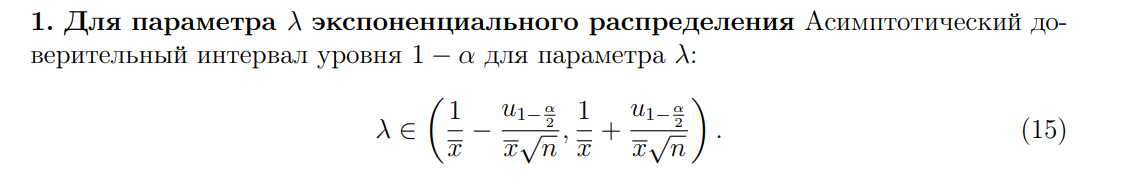

In [5]:
# Экспоненциальное
# Посчитаем выборочное среднее
sample_mean_exp = sum(distributions["exponential"]) / distr_size
deviation = get_gauss_quantile(1 - error / 2) / (sample_mean_exp * distr_size ** 0.5)
a_lam_e = 1 / sample_mean_exp - deviation
b_lam_e = 1 / sample_mean_exp + deviation
print(f"Interval for lambda in exponential: [{a_lam_e}; {b_lam_e}]")

Interval for lambda in exponential: [2.5579681118911246; 3.3810603357405515]


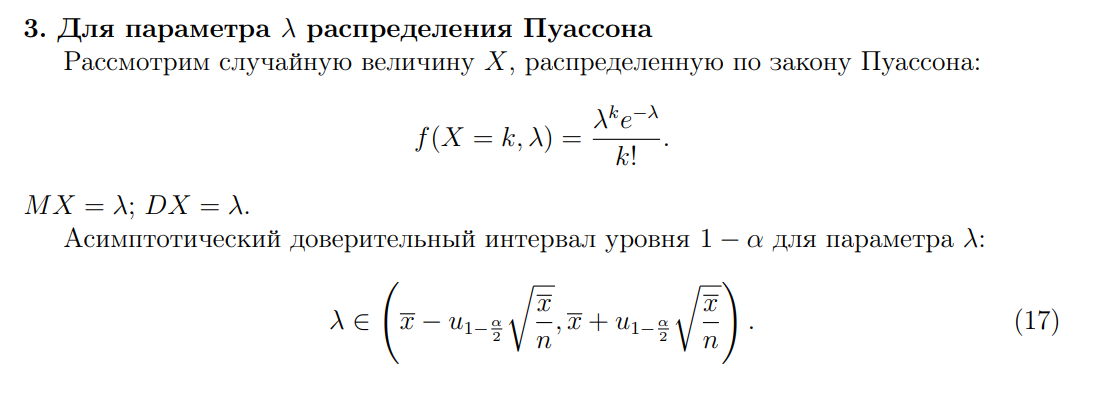

In [6]:
# Пуассон
sample_mean_poiss = sum(distributions["poisson"]) / distr_size
deviation = get_gauss_quantile(1 - error / 2) * (sample_mean_poiss / distr_size) ** 0.5
a_lam_poiss = sample_mean_poiss - deviation
b_lam_poiss = sample_mean_poiss + deviation
print(f"Interval for lambda in poisson: [{a_lam_poiss}; {b_lam_poiss}]")

Interval for lambda in poisson: [7.725078199993743; 8.514921800006256]


## Задание 2: Ядерные оценки
___

### 1)Введем функцию для ядра Гаусса и для ширины окна:

In [35]:
from math import pi, exp

def gauss_kernel(x):
    g_k = lambda t: exp(-t ** 2 / 2) / (2 * pi) ** 0.5
    return (np.vectorize(g_k))(x)


def get_window(distr):
  # Посчитаем корень из исправленной выборочной дисперсии:
  sample_mean = sum(distr) / distr.size
  correction = distr.size / (distr.size - 1)
  s_n = correction * sum((distr - sample_mean) ** 2) / distr.size
  return (1.06 * s_n) / distr.size ** (1/5)

### 2) Создадим класс для ядерной оценки плотности

In [36]:
class KernelMarker:
  def __init__(self, distr):
    self.distr = distr
    self.h = get_window(self.distr)
  
  # Возвращает ядерную оценку плотности 
  def get_f(self, x):
    kern_sum = 0
    for el in self.distr:
      kern_sum += gauss_kernel((x - el) / self.h)
    return 1 / (self.distr.size * self.h) * kern_sum

### 3) Построим ядерную оценку плотности для N(9, 14), n = 200

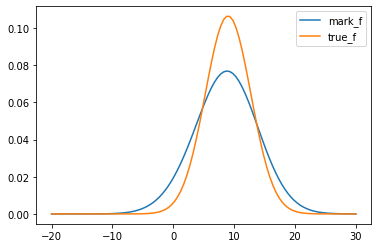

In [41]:
distr_size = 200
loc=9
scale=14**0.5
gauss_distr = st.norm.rvs(size=distr_size, loc=loc, scale=scale)
gauss_marker = KernelMarker(gauss_distr)
x = np.linspace(-20, 30, 100)
# print(gauss_marker.get_f(1))
plt.plot(x, gauss_marker.get_f(x), label="mark_f")
plt.plot(x, st.norm.pdf(x, loc=loc, scale=scale), label="true_f")
plt.legend()
plt.show()

### 4) Построим ядерную оценку плотности для нормального распределния

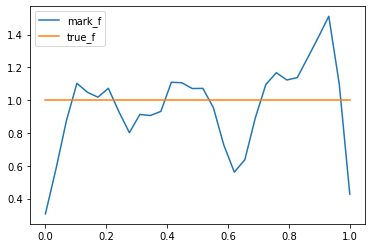

In [38]:
distr_size = 200
uniform_distr = st.uniform.rvs(size=distr_size)

uniform_marker = KernelMarker(uniform_distr)
x = np.linspace(0, 1, 30)
plt.plot(x, uniform_marker.get_f(x), label = "mark_f")
plt.plot(x, st.uniform.pdf(x), label = "true_f")
plt.legend()
plt.show()

## Задание 3: Регрессии

Одна величина зависит от другой по формуле: $ξ = 2 + 5\eta + ϵ * \begin{cases} N(0, 1) \\ Uniform [-3, 3] \\ Caushy (0, 1) \end{cases}$ \\
$\eta \in N(0, 1), \epsilon = 0.01$


### 1) Зададим функцию зависимости одной случайной величины от другой:

In [11]:
def lin_func(x):
  return 2 + 5 * x

In [42]:
def get_xi(eta, noise):
  epsilon = 0.1
  return lin_func(eta) + epsilon * noise 

In [13]:
def get_y_mass(x_mass, noise_func):
  y_mass = []
  for el in x_mass:
    y_mass.append(get_xi(el, noise_func()))
  return np.array(y_mass)

In [14]:
def get_sample_mean(distr):
  return sum(distr) / distr.size

In [15]:
def get_sample_dispersion(distr):
  sample_mean = get_sample_mean(distr)
  return sum((distr - sample_mean) ** 2) / distr.size

In [16]:
def get_sample_correlation(x_mass, y_mass):
  x_sample_mean = get_sample_mean(x_mass)
  y_sample_mean = get_sample_mean(y_mass)
  cov = 0
  for i in range(x_mass.size):
    cov += (x_mass[i] - x_sample_mean) * (y_mass[i] - y_sample_mean)
  cov /= x_mass.size
  return cov / (get_sample_dispersion(x_mass) * get_sample_dispersion(y_mass)) ** 0.5

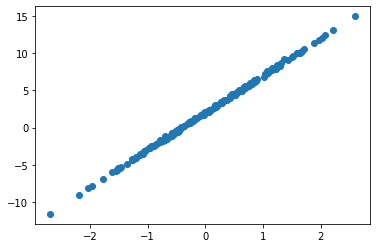

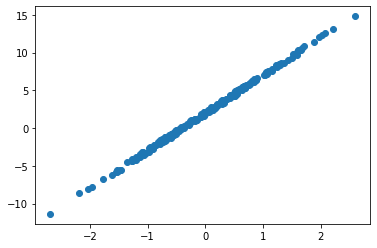

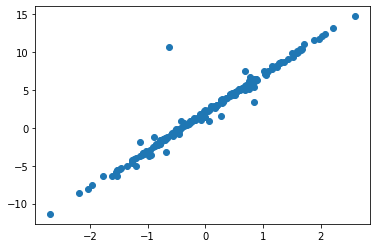

In [43]:
distr_size = 200
x_mass = st.norm.rvs(size=distr_size) 
y_mass_ns = {
    "gauss": get_y_mass(x_mass, st.norm.rvs),
    "uniform": get_y_mass(x_mass, lambda: st.uniform.rvs(loc=-3, scale=6)), 
    "causy": get_y_mass(x_mass, st.cauchy.rvs)
}

for y_mass_key in y_mass_ns:
  # print("x mean: ", get_sample_mean(x_mass), "y mean: ", get_sample_mean(y_mass_ns[y_mass_key]))
  plt.scatter(x_mass, y_mass_ns[y_mass_key])
  plt.show()

### 2) Построим линейную регрессию и графики невязок:

In [18]:
class LinRegr:
  def __init__(self, corr, x_mean, y_mean, x_disp, y_disp):
    self.corr = corr
    self.x_mean = x_mean
    self.y_mean = y_mean
    self.x_sko = x_disp ** 0.5
    self.y_sko = y_disp ** 0.5
  
  def get_appr_y(self, x):
    return self.corr * self.y_sko * x / self.x_sko + self.y_mean - self.corr * self.y_sko * self.x_mean / self.x_sko

0.9997512161969105 0.029016621796241836 2.1484969503504816 0.8851710561383433 22.117793936526315
0.9993849866984419 0.029016621796241836 2.170743858176721 0.8851710561383433 22.23819626893356
0.9804449179802723 0.029016621796241836 2.1809710704204703 0.8851710561383433 22.584527013791416


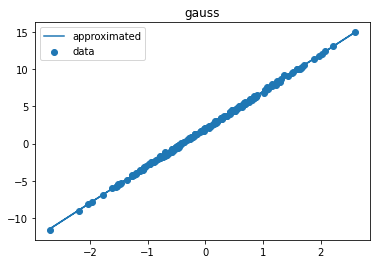

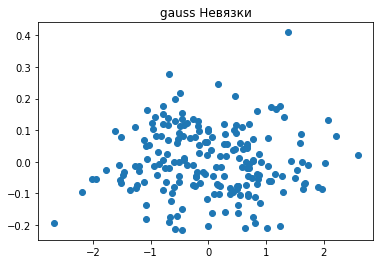

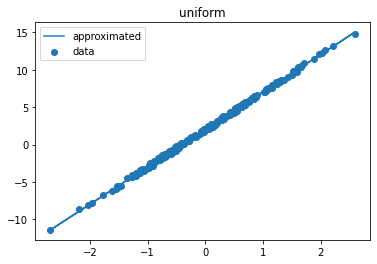

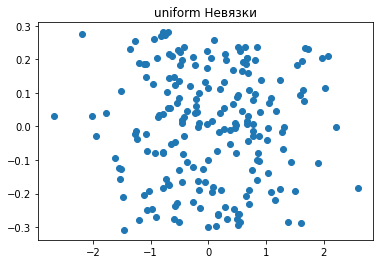

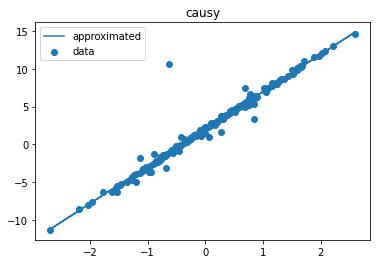

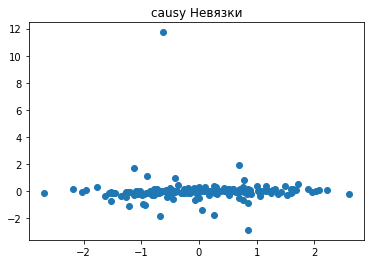

In [44]:
y_appr_func = {}
for key in y_mass_ns:
  print(get_sample_correlation(x_mass, y_mass_ns[key]), get_sample_mean(x_mass), get_sample_mean(y_mass_ns[key]),
  get_sample_dispersion(x_mass), get_sample_dispersion(y_mass_ns[key]))

  y_appr_func[key] = LinRegr(get_sample_correlation(x_mass, y_mass_ns[key]), get_sample_mean(x_mass), get_sample_mean(y_mass_ns[key]),
  get_sample_dispersion(x_mass), get_sample_dispersion(y_mass_ns[key])).get_appr_y

# x = np.linspace(-0.01, 0.01, 50)
for key in y_mass_ns:
  plt.scatter(x_mass, y_mass_ns[key], label = "data")
  plt.plot(x_mass, y_appr_func[key](x_mass), label = "approximated")
  plt.legend()
  plt.title(key)
  plt.show()
  plt.scatter(x_mass, y_mass_ns[key] - y_appr_func[key](x_mass))
  plt.title(key + " Невязки")
  plt.show()
  

### 3) Построим доверительный интервал для коэффициента корреляции (Пирсона)
Будем строить аппроксимируя через преобразование Фишера.

In [20]:
# Посчитаем коэффициенты корреляции для всех y с разным шумом:
sample_corrs = {}
for key in y_mass_ns:
  sample_corrs[key] = get_sample_correlation(x_mass, y_mass_ns[key])


Выполним преобразование Фишера:

In [21]:
from math import log

z = {}
for key in sample_corrs:
  z[key] = 0.5 * log((1 + sample_corrs[key]) / (1 - sample_corrs[key]))

# Теперь посчитаем интервалы для всех z:
error = 0.05
deviation = get_gauss_quantile(1 - error / 2) * 1 / (x_mass.size - 3) ** 0.5

a_z = {}
b_z = {}
for key in z:
  a_z[key] = z[key] - deviation
  b_z[key] = z[key] + deviation
  print(f'{key}: z = {z[key]} [{a_z[key]}; {b_z[key]}]')



gauss: z = 6.886048431649984 [6.746406779668956; 7.025690083631011]
uniform: z = 6.364230257699715 [6.224588605718687; 6.5038719096807425]
causy: z = 1.4465425177435698 [1.306900865762542; 1.5861841697245975]


Сделаем обратное преобразование и выведем полученные доверительные интервалы для коэффициента корреляции:

In [22]:
for key in a_z:
  e_l = exp(2 * a_z[key])
  a_corr = (e_l - 1) / (e_l + 1)
  e_u = exp(2 * b_z[key])
  b_corr = (e_u - 1) / (e_u + 1)
  print(f'{key}: sample_corr = {sample_corrs[key]} confidence interval: [{a_corr}; {b_corr}], interval_size = {b_corr - a_corr}')

gauss: sample_corr = 0.99999791126247 confidence interval: [0.9999972383100355; 0.9999984202339264], interval_size = 1.181923890869463e-06
uniform: sample_corr = 0.9999940689915497 confidence interval: [0.9999921581356476; 0.999995514223217], interval_size = 3.3560875694060854e-06
causy: sample_corr = 0.8950070900617753 confidence interval: [0.8634891415601597; 0.9195622105161256], interval_size = 0.05607306895596598


### 4) Проведем группирование

Сначала объединим x и y в пары, чтобы было удобнее работать

In [23]:
pairs = {}
for key in y_mass_ns:
  pairs[key] = []
  for i in range(x_mass.size):
    pairs[key].append((x_mass[i], y_mass_ns[key][i]))
  

Теперь надо создать сетку:

In [24]:
# dot is a pair [0] - x, [1] - y
class Square:
    def __init__(self, left_corner_dot, width, height):
        self.left_corner_dot = left_corner_dot
        self.width = width
        self.height = height
        self.frequency = 0

    def set_frequency(self, dots):
        for dot in dots:
            if self.left_corner_dot[0] <= dot[0] < self.left_corner_dot[0] + self.width:
              if self.left_corner_dot[1] <= dot[1] < self.left_corner_dot[1] + self.height:
                self.frequency += 1

    def get_centre_x(self):
      return self.left_corner_dot[0] + self.width / 2 

    def get_centre_y(self):
      return self.left_corner_dot[1] + self.height / 2 

    def __str__(self):
        return f"[x: {self.left_corner_dot[0]}; {self.left_corner_dot[0] + self.width}] [y: {self.left_corner_dot[1]}; {self.left_corner_dot[1] + self.height}] - {self.frequency}"

In [ ]:
# Теперь сделаем сетку. Это двумерный массив, 00 - левый нижний, k-1 k-1 - правый верхний угол
k = 10
x_min = min(x_mass)
x_cell_size = (max(x_mass) - x_min) / k
# Пока сделаем для одного:
y_cell_size = {}
setka = {}
for key in y_mass_ns:
  y_min = min(y_mass_ns[key])
  print(max(y_mass_ns[key]))
  y_cell_size[key] = (max(y_mass_ns[key]) - y_min) / k
  setka[key] = [[0 for j in range(k)] for i in range(k)]
  # При росте i увеличивается y!
  for i in range(k):
    for j in range(k):
      left_corner = (x_min + j * x_cell_size, y_min + i * y_cell_size[key])
      setka[key][i][j] = Square(left_corner, x_cell_size, y_cell_size[key])
      setka[key][i][j].set_frequency(pairs[key])
      print(key, " ", setka[key][i][j])

Теперь посчитаем выборочный группированный коэффициент корреляции:

In [31]:
# Посчитаем среднее по x и y
group_mean_x = {}
group_mean_y = {}

for key in setka:
  group_mean_x[key] = 0
  group_mean_y[key] = 0 
  for i in range(k):
    for j in range(k):
      group_mean_x[key] += setka[key][i][j].get_centre_x() * setka[key][i][j].frequency
      group_mean_y[key] += setka[key][i][j].get_centre_y() * setka[key][i][j].frequency
  group_mean_x[key] /= x_mass.size
  group_mean_y[key] /= x_mass.size
  # print(key, "x_gr_mean: ", group_mean_x[key], "y_gr_mean: ", group_mean_y[key])

# Посчитаем выборочный коэффициент корреляции при груп
n_str = {}
n_col = {}

for key in setka:
  n_str[key] = [0 for j in range(k)]
  n_col[key] = [0 for j in range(k)]
  
  for i in range(k):
    for j in range(k):
      n_str[key][i] += setka[key][i][j].frequency
  
  for j in range(k):
    for i in range(k):
      n_col[key][j] += setka[key][i][j].frequency
  
  # print(f"{key}: n_str: {n_str[key]}; n_col: {n_col[key]}")
otkl_x = {}
otkl_y = {}

for key in setka:
  otkl_x[key] = 0
  otkl_y[key] = 0
  for i in range(k):
    otkl_x[key] += (setka[key][0][i].get_centre_x() - group_mean_x[key]) ** 2 * n_str[key][i] 
    otkl_y[key] += (setka[key][i][0].get_centre_y() - group_mean_y[key]) ** 2 * n_col[key][i]


group_mean_corr = {}
for key in setka:
  group_mean_corr[key] = 0
  for i in range(k):
    for j in range(k):
      counter = (setka[key][i][j].get_centre_x() - group_mean_x[key]) * (setka[key][i][j].get_centre_y() - group_mean_y[key]) * setka[key][i][j].frequency
      delimiter = (otkl_x[key] * otkl_y[key]) ** 0.5
      group_mean_corr[key] += counter / delimiter
  print(f"{key}: {group_mean_corr[key]}")

gauss: 0.9992102453438859
uniform: 0.997626380031636
causy: 0.3228737454288374


Выполним преобразование Фишера:

In [ ]:
from math import log

z_gr = {}
for key in group_mean_corr:
  z_gr[key] = 0.5 * log((1 + group_mean_corr[key]) / (1 - group_mean_corr[key]))

# Теперь посчитаем интервалы для всех z:
error = 0.05
deviation = get_gauss_quantile(1 - error / 2) * 1 / (k - 3) ** 0.5

a_z_gr = {}
b_z_gr = {}
for key in z_gr:
  a_z_gr[key] = z_gr[key] - deviation
  b_z_gr[key] = z_gr[key] + deviation
  print(f'{key}: z_gr = {z_gr[key]} [{a_z_gr[key]}; {b_z_gr[key]}]')


Сделаем обратное преобразование и выведем полученные доверительные интервалы для коэффициента корреляции:

In [33]:
for key in a_z_gr:
  e_l_gr = exp(2 * a_z_gr[key])
  a_corr_gr = (e_l_gr - 1) / (e_l_gr + 1)
  e_u_gr = exp(2 * b_z_gr[key])
  b_corr_gr = (e_u_gr - 1) / (e_u_gr + 1)
  print(f'{key}: sample_corr = {group_mean_corr[key]} confidence interval: [{a_corr_gr}; {b_corr_gr}], interval_size = {b_corr_gr - a_corr_gr}')

gauss: sample_corr = 0.9992102453438859 confidence interval: [0.9965297768435192; 0.9998204535400341], interval_size = 0.003290676696514949
uniform: sample_corr = 0.997626380031636 confidence interval: [0.9895981597818572; 0.9994600397796618], interval_size = 0.009861879997804635
causy: sample_corr = 0.3228737454288374 confidence interval: [-0.38502400956192795; 0.7915799206234805], interval_size = 1.1766039301854083
